# A copy of the F=ma model, but it doesn't normalize input data.

In [1]:
import numpy as np
from scipy.integrate import odeint
import tensorflow as tf
import matplotlib.pyplot as plt
%load_ext tensorboard

## Generate training data (incl. noise)

In [8]:
# Multiple linear inputs
Nds = [1000, 2000, 1000, 2000, 1000, 2000, 1000, 2000, 1000, 3000] # List of lengths of given data
Nseg = len(Nds) # Number of segments
Nd = sum(Nds)
dt = 0.01

# System parameters
m = 2

# Define analytical solutions as functions in this case, because it's more convenient
# For future cases, try using ode solvers for data synthesis
# Here we have input force u(t) = u_0 + u_1*t. The acceleration is then a = u(t)/m.
# From dv = a, this gives v(t) = v_0 + u_0/m * t + u_1/2/m * t^2.
# From dx = v, this gives x(t) = x_0 + v_0 * t + u_0/2/m * t^2 + u_1/6/m * t^3 as output.
# Input parameters: t_cumulative is a 1D array of cumulative timestep values (not necessarily starting from 0)
def fma_dynamics(t_cumulative, u_params=[1,0], m=1, x0=0, v0=0):
    t = t_cumulative - t_cumulative[0]
    u = u_params[0] + u_params[1] * t
    x = x0 + v0 * t + u_params[0]/2/m * t*t + u_params[1]/6/m * t*t*t
    return u, x

# For each segment, generate time data and input-output data
t_list = []
u_list = []
x_list = []
# Initial conditions for each segment - to make the start easier, use zero initial conditions for now
x0_segs = np.zeros(Nseg)
v0_segs = np.zeros(Nseg)
# t_offset = [10, 210, 3001, 517, -123, 3.3, -314.159] # Offsets to add on each time segment
t_offset = np.zeros(Nseg)
# u_params = [ [1,1], [2,1], [-1,1], [-1,0], [2,-2], [3,1.1], [-0.3,1.2] ] # Input parameters for each segment
u_params = [[0,1],[0,-1],[1,0],[-1,0],[1,1],[1,-1],[-1,1],[-1,-1],[-1,0.3],[3,-0.2]]
for seg_ind in range(Nseg):
    t_seg = np.cumsum(np.full((1, Nds[seg_ind]), dt)) + t_offset[seg_ind] # Timesteps for this segment
    (u_seg, x_seg) = fma_dynamics(t_seg, u_params = u_params[seg_ind], m=m, x0 = x0_segs[seg_ind], v0 = v0_segs[seg_ind])
    # Store the generated data
    t_list.append(t_seg)
    u_list.append(u_seg)
    x_list.append(x_seg)
# Turn the stored data into input data arrays
t = np.concatenate(t_list)
x = np.concatenate(x_list)
x = np.log(x-x.min()+1)
u = np.concatenate(u_list)

# Stack'em
Dataset = np.vstack((t,u,x))
Dataset_time_ind = 0
Dataset_input_ind = 1
Dataset_output_ind = 2

# Function for adding noise & normalizing. Note: Data isn't modified by reference
def add_proportional_noise(data, noise_level=0, noiseless_inds=[]):
    # This method adds noise based on each data value's magnitude
    # Arguments:
    # data: the pure data to be polluted
    # noise_level: noise variance specified as the percentage of true data
    # noiseless_inds: Index of rows that shouldn't receive noise
    Nrows = np.size(data,0)
    Ncols = np.size(data,1)
    for row_ind in range(Nrows):
        if row_ind not in noiseless_inds:
            data[row_ind] *= (1 + np.random.normal(0, noise_level, Ncols))
    return data

def add_noise(data, noise_level=0, noiseless_inds=[]):
    # This method adds noise regardless of data value's magnitude
    # Arguments:
    # data: the pure data to be polluted
    # noise_level: noise variance (absolute value)
    # noiseless_inds: Index of rows that shouldn't receive noise
    Nrows = np.size(data,0)
    Ncols = np.size(data,1)
    for row_ind in range(Nrows):
        if row_ind not in noiseless_inds:
            data[row_ind] += np.random.normal(0, noise_level, Ncols)
    return data

# Maybe there could also be a method where noise level can be specified for each row

noise_var = 0 # Noise variance (if any)
add_proportional_noise(Dataset, noise_level = noise_var, noiseless_inds = [Dataset_time_ind,Dataset_input_ind])

array([[ 1.00000000e-02,  2.00000000e-02,  3.00000000e-02, ...,
         2.99800000e+01,  2.99900000e+01,  3.00000000e+01],
       [ 0.00000000e+00,  1.00000000e-02,  2.00000000e-02, ...,
        -2.99400000e+00, -2.99600000e+00, -2.99800000e+00],
       [ 6.64192235e+00,  6.64192235e+00,  6.64192236e+00, ...,
         6.89928603e+00,  6.89928641e+00,  6.89928664e+00]])

## Data synthesizer for F=ma

In [24]:
# Function that outputs dynamics dx/dt when given current states
def fma(x, t, u=lambda x : 0):
    # Arguments: x = [velocity, position]^T, t = current time.
    # Output: dx/dt= [input u , velocity]^T
    # Assumes scalar.
    return np.array([x[1], u(t)])

# Synthesizes data based on input. Uses odeint solver.
def fma_generator(t_interval=[0,1], dt=0.01, init=None, u=lambda x : 0):
    # Arguments: [start time, end time], time interval, initial conditions, input function
    t = np.arange(t_interval[0], dt, t_interval[1])
    if init is None:
        init = np.array([0, 0])
    x = odeint(func=fma, y0=init, t=t, args=(u,)) # (u,) creates an one-element tuple
    # Returns an array where first row is time, and 2nd~last rows are states
    return np.vstack((t, x.T))

# Generate data similar to the above procedure, but this time in function
def fma_batch_generator(t_list, u_list, init_conds=None, dt=0.01, noise_level=0):
    # Arguments: 
    # t_list: List of start-end time tuples
    # u_list: list of input functions
    
    data_list = []
    input_list = []
    
    Nseg = t_list.shape[1]
    # Initial conditions of each segment
    if init_conds is None:
        init_conds = np.zeros((2, Nseg))
    
    # Generate data for each segment
    for i in range(Nseg):
        data_list.append( fma_generator(t_list[:,i], dt, init_conds[:,i], u_list[i]) )
        # Regenerate time history
        input_list.append( [u_list[i](t) for t in data_list[i][0,:]] )
    
    # Put together as one matrix with time-input data, and one with output data
    data_list = np.concatenate(data_list, axis=1)
    input_list = np.concatenate(input_list)
    time_input_data = np.vstack((data_list[0,:], input_list))
    output_data = np.reshape(data_list[2,:], (1, data_list.shape[1])) # Only position is observed
    
    # Add noise to observation. 
    output_data += noise_level * output_data * np.random.randn(1, output_data.shape[-1])
    
    return time_input_data, output_data

# For this case, we excite the system with sinusoidal inputs.
# Additionally, we regulate the form of time, so that the NN gets less surprise.
Nd_seg = 1000
Nseg = 10
t_list = np.array([[0,Nd_seg]] * Nseg).T
u_params = np.vstack((
    np.random.uniform(0.5, 1, (1, Nseg)), # Magnitudes
    np.random.uniform(0.02, 0.1, (1, Nseg))*np.pi*2, # frequencies
    np.random.uniform(0, np.pi, (1,Nseg)) # Phases
))
u_func_list = [( lambda t : u_params[0,i] * np.sin(u_params[1,i]*t+u_params[2,i]) ) for i in range(Nseg)]
(Inputset, Outputset) = fma_batch_generator(t_list, u_func_list, noise_level=0.1)

## Data batch preprocessor

In [30]:
# Segments input data into numerous training timeframes
def framing(input_data, output_data, frame_size, start_index=0, end_index=None, pred_size=1):
    # Arguments:
    # input_data: The training input data that is to be made into overlapping frames. Should be 2D.
    # output_data: The labels of corresponding input data. Will be made into matching frames.
    # Outputs:
    # 
    if end_index is None:
        end_index = input_data.shape[-1] - frame_size
        
    # Generate data by splitting it into successive overlapping frames.
    # Its first dimension is going to be samples. Each 2D sample occupies the 2nd and 3rd.
    Nframes = end_index-start_index - pred_size
    input_frames = np.zeros((Nframes, input_data.shape[0], frame_size))
    output_data = np.reshape(output_data, (-1,output_data.shape[-1])) # Force into 2D
    output_frames = np.zeros((Nframes, output_data.shape[0], frame_size)) # , output_data.shape[1]))
    pred_frames = []
    
    for i in range(Nframes):
        input_frames[i,:,:] = input_data[:,i:i+frame_size]
        output_frames[i,:,:] = output_data[:,i:i+frame_size]
    
    # Also offer complementary future state if you're into predictions
    if pred_size > 0:
        pred_frames = np.zeros((Nframes, input_data.shape[0], pred_size))
        for i in range(Nframes):
            pred_frames[i,:,:] = input_data[:, i+frame_size:i+frame_size+pred_size]
    
    return input_frames, output_frames, pred_frames

# Generate data
frame_size = 4
(InputFset, OutputFset, PredictFset) = framing(Inputset, Outputset, frame_size=frame_size)

## Plot training data for visual inspection

Text(0.5, 0.98, 'Training data')

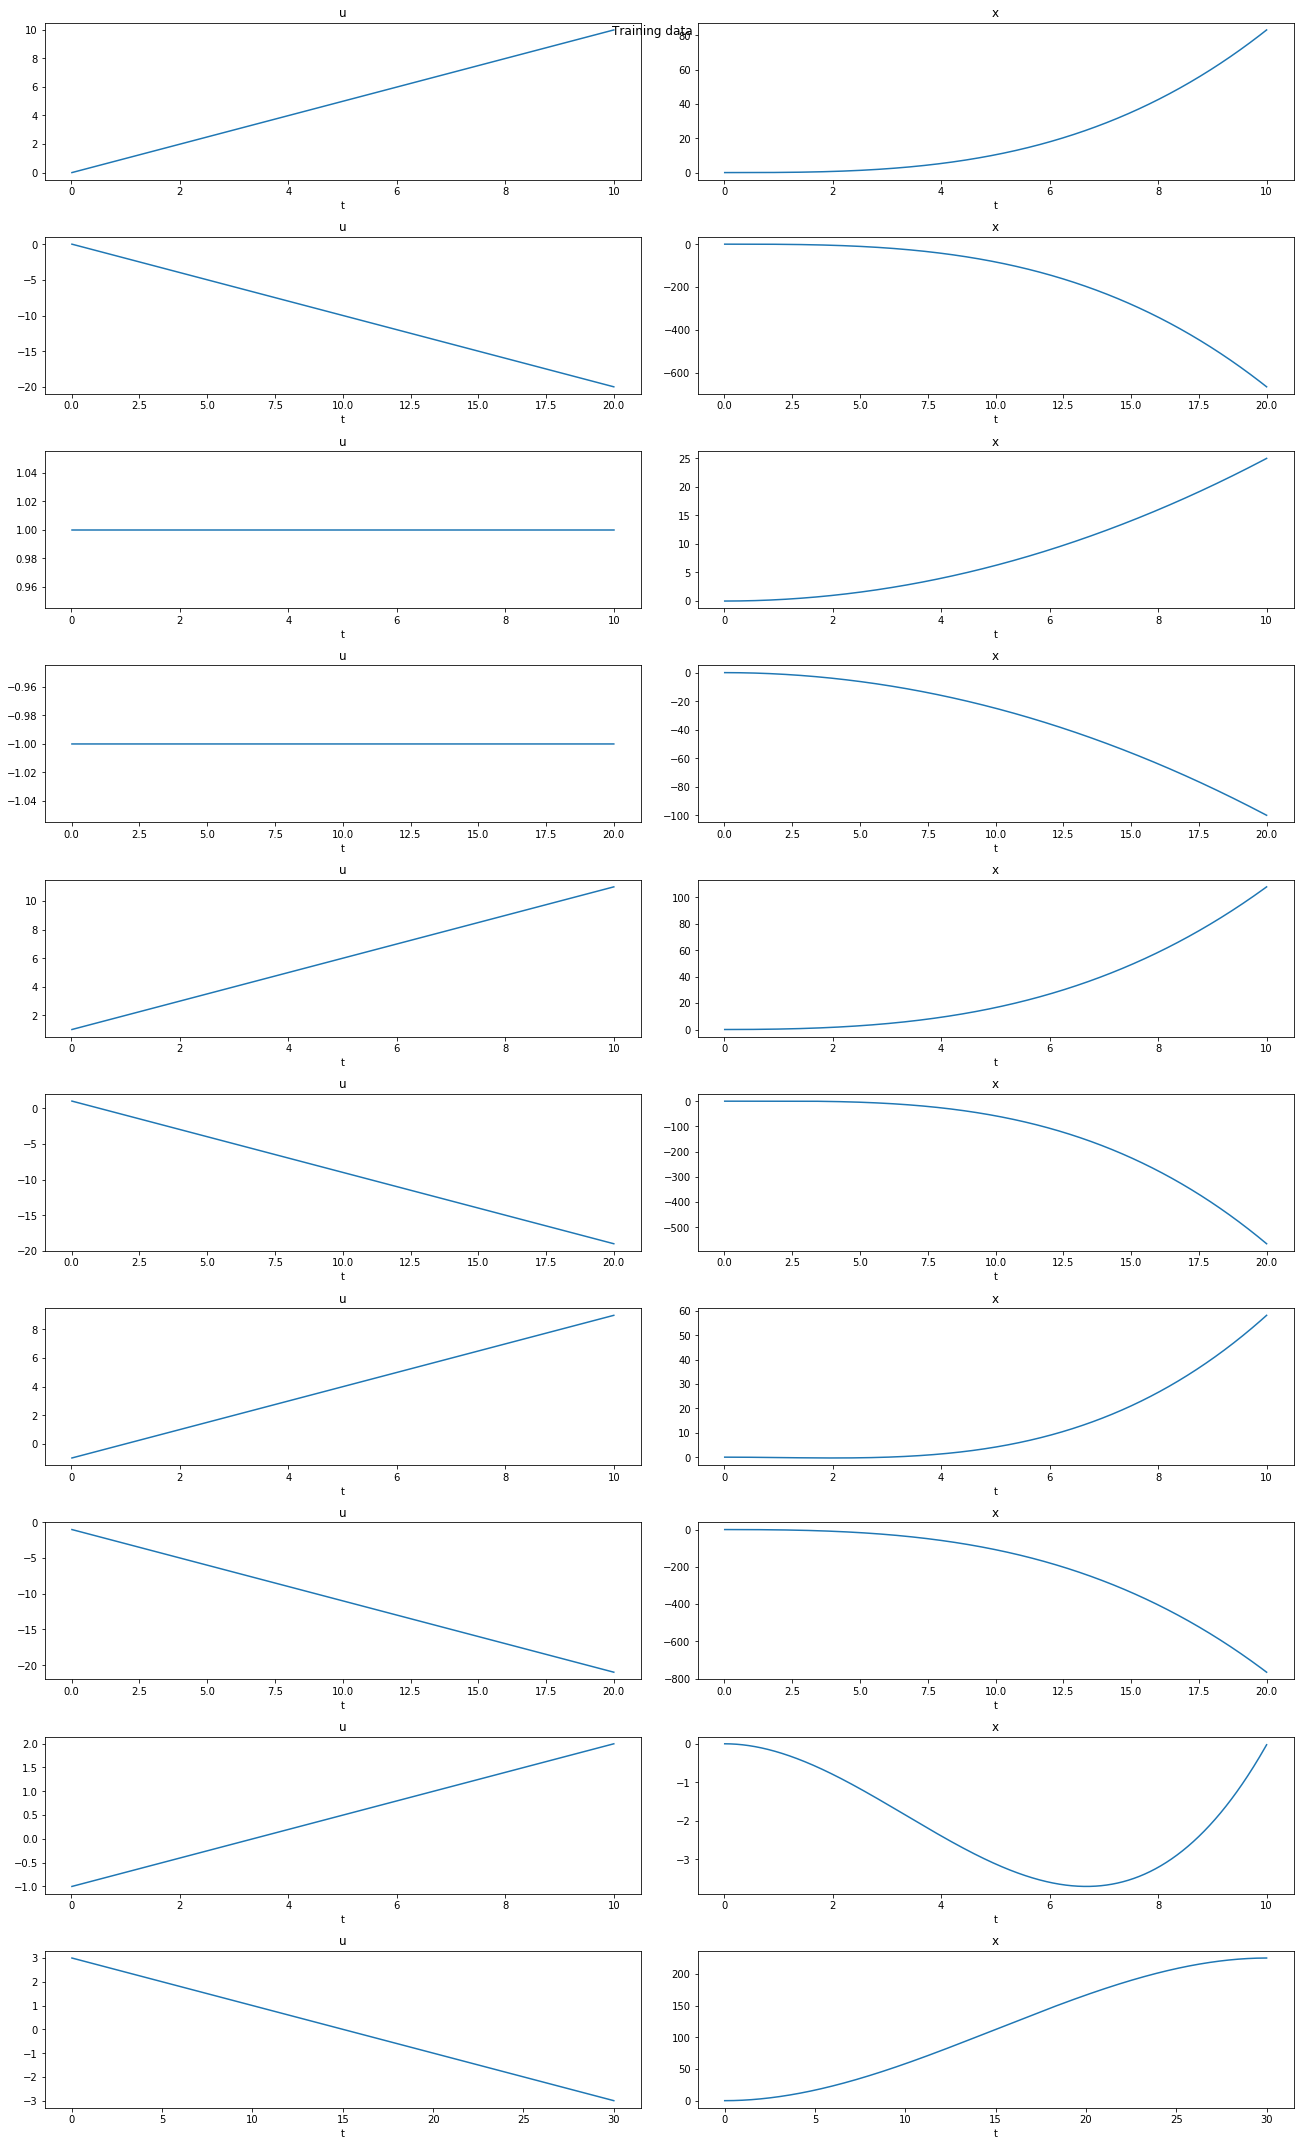

In [16]:
fig,axs = plt.subplots(Nseg, 2, constrained_layout=True, figsize = (18,30))

# Generate correct answer for each test, as well as run input through prediction
for seg_ind in range(Nseg):
    # Plot both cases
    axs[seg_ind][0].plot(t_list[seg_ind], u_list[seg_ind])
    axs[seg_ind][0].set_title('u')
    axs[seg_ind][0].set_xlabel('t')
    axs[seg_ind][1].plot(t_list[seg_ind], x_list[seg_ind])
    axs[seg_ind][1].set_title('x')
    axs[seg_ind][1].set_xlabel('t')
fig.suptitle('Training data')

# Construct neural nets

In [9]:
# Set seed to ensure reprodicibility
tf.random.set_seed(2020)
# Clear previous model
tf.keras.backend.clear_session()
# Clear any Tensorboard logs from previous runs
!rm -rf ./fma_nonormal_logs/ 
# Set log directory for tensorboard visualization later
log_dir = "fma_nonormal_logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Choose your net

In [ ]:
# 1-layer, each with 4 neurons
Activation = tf.keras.activations.tanh
Nneuron = 4
model_4 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(Nneuron, activation = Activation, input_shape = Dataset[Dataset_time_ind:Dataset_output_ind,0].shape),
    tf.keras.layers.Dense(1)  # Output
])
Nlayer = 1
Epoch = 40

# Loss function: Use the simplest squared error for now
model_1.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)

In [ ]:
# 2-layer, each with 4 neurons
Activation = tf.keras.activations.tanh
Nneuron = 4
model_4 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(Nneuron, activation = Activation, input_shape = Dataset[Dataset_time_ind:Dataset_output_ind,0].shape),
    tf.keras.layers.Dense(Nneuron, activation = Activation),
    tf.keras.layers.Dense(1)  # Output
])
Nlayer = 2
Epoch = 40

# Loss function: Use the simplest squared error for now
model_2.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)

In [10]:
# 4-layer, each with 16 neurons... Too complicated!
Activation = tf.keras.activations.tanh
Nneuron = 16
model_4 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(Nneuron, activation = Activation, input_shape = Dataset[Dataset_time_ind:Dataset_output_ind,0].shape),
    tf.keras.layers.Dense(Nneuron, activation = Activation),
    tf.keras.layers.Dense(Nneuron, activation = Activation),
    tf.keras.layers.Dense(Nneuron, activation = Activation),
    tf.keras.layers.Dense(1)  # Output
])
Nlayer = 4
Epoch = 40

# Loss function: Use the simplest squared error for now
model_4.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)

Train

In [11]:
# Note: Might need to tune parameters such as batch_size, validation_split, etc? (batch_size is by default 32)
model = model_4
history = model.fit(Dataset[Dataset_time_ind:Dataset_output_ind,:].reshape((Nd, Dataset_output_ind)), 
                    Dataset[Dataset_output_ind:,:].reshape((Nd, np.size(Dataset,0)-Dataset_output_ind)), 
                    epochs = Epoch, callbacks=[tensorboard_callback]) 

Train on 16000 samples
Epoch 1/40
16000/16000 [==============================] - 1s 54us/sample - loss: 5.4653
Epoch 2/40
16000/16000 [==============================] - 1s 31us/sample - loss: 0.1292
Epoch 3/40
16000/16000 [==============================] - 0s 30us/sample - loss: 0.1243
Epoch 4/40
16000/16000 [==============================] - 0s 31us/sample - loss: 0.1212
Epoch 5/40
16000/16000 [==============================] - 1s 32us/sample - loss: 0.1205
Epoch 6/40
16000/16000 [==============================] - 1s 32us/sample - loss: 0.1199
Epoch 7/40
16000/16000 [==============================] - 1s 32us/sample - loss: 0.1174
Epoch 8/40
16000/16000 [==============================] - 0s 31us/sample - loss: 0.1150
Epoch 9/40
16000/16000 [==============================] - 0s 31us/sample - loss: 0.1188
Epoch 10/40
16000/16000 [==============================] - 0s 31us/sample - loss: 0.1164
Epoch 11/40
16000/16000 [==============================] - 1s 34us/sample - loss: 0.1152
Epoch 1

# Check prediction performance by visualizing it

Text(0.5, 0.98, 'Model trained with 4 layers, each with 16 neurons')

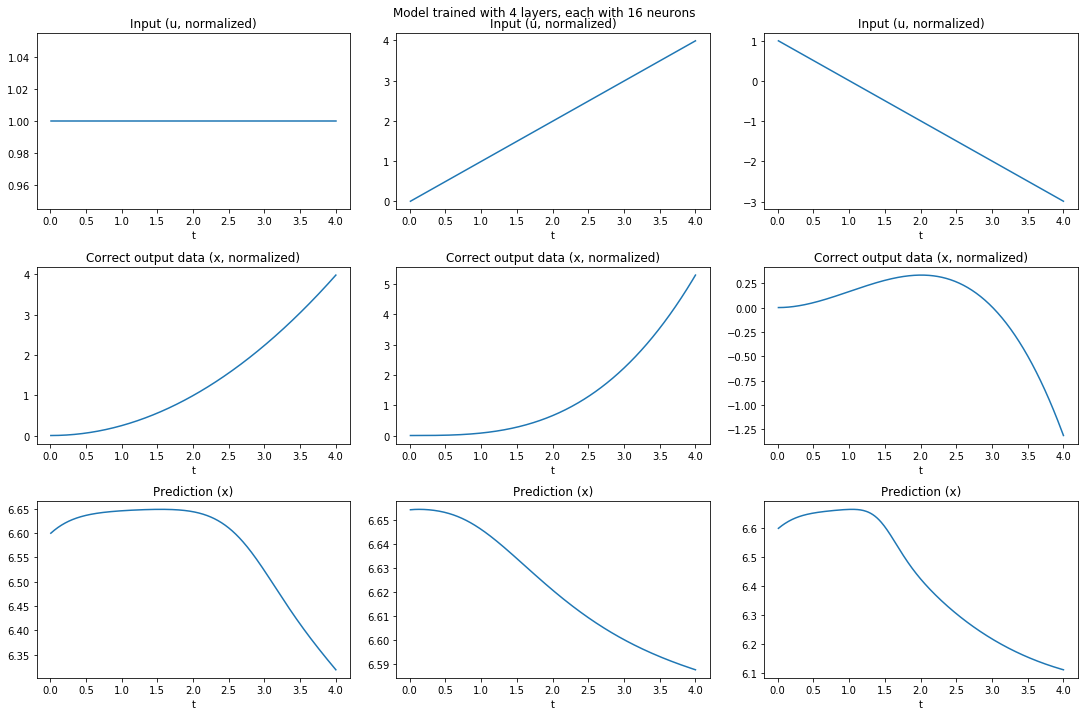

In [12]:
# Prepare test set
Nds_test = [400, 400, 400]
Nseg_test = len(Nds_test)
t_offset_test = [0, 0, 0]
u_params_test = [[1, 0], [0, 1], [1, -1]] # Try some simpler cases...
x0_segs_test = np.zeros(Nseg_test)
v0_segs_test = np.zeros(Nseg_test)
# m = 2 # This should be universal for all cases. This represents the systems dynamic.

fig,axs = plt.subplots(3, Nseg_test, constrained_layout=True, figsize = (15,10))

# Generate correct answer for each test, as well as run input through prediction
for seg_ind in range(Nseg_test):
    # Generate time, input, and correct output
    t_seg = np.cumsum(np.full((1, Nds_test[seg_ind]), dt)) + t_offset_test[seg_ind] # Timesteps for this segment
    (u_seg, x_seg) = fma_dynamics(t_seg, u_params = u_params_test[seg_ind], m=m, 
                                         x0 = x0_segs_test[seg_ind], v0 = v0_segs_test[seg_ind])
#     u_seg = tf.keras.utils.normalize(u_seg).flatten()
#     x_seg = tf.keras.utils.normalize(x_seg).flatten() # Normalize the input and outputs
    
    # Generate predictions
    inputs = np.vstack((t_seg, u_seg))
    # result = [model.predict(inputs[:,i]) for i in range(np.size(inputs, 1))]
    result = model.predict(inputs.T) # Reshape the input with size (2,Nds) into (_, 2).
    result = np.array(result).reshape(Nds_test[seg_ind])
    # tf.keras.utils.normalize(
    
    # Plot both cases
    axs[0][seg_ind].plot(t_seg, u_seg)
    axs[0][seg_ind].set_title('Input (u, normalized)')
    axs[0][seg_ind].set_xlabel('t')
    axs[1][seg_ind].plot(t_seg, x_seg)
    axs[1][seg_ind].set_title('Correct output data (x, normalized)')
    axs[1][seg_ind].set_xlabel('t')
    axs[2][seg_ind].plot(t_seg, result)
    axs[2][seg_ind].set_title('Prediction (x)')
    axs[2][seg_ind].set_xlabel('t')
fig.suptitle('Model trained with %d layers, each with %d neurons' % (Nlayer, Nneuron))

## Inspect net structure

In [13]:
%tensorboard --logdir fma_nonormal_logs/fit

Reusing TensorBoard on port 6007 (pid 97910), started 1:38:38 ago. (Use '!kill 97910' to kill it.)